In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
train_dir = '/content/drive/MyDrive/brain_tumor_dataset/train-20250715T152614Z-1-001/train'
test_dir = '/content/drive/MyDrive/brain_tumor_dataset/test-20250715T152614Z-1-001/test'
valid_dir = '/content/drive/MyDrive/brain_tumor_dataset/valid-20250715T152941Z-1-001/valid'

In [3]:
import os

print(os.listdir(train_dir))

['_classes.csv', 'pituitary', 'glioma', 'meningioma', 'no_tumor']


**Understand the Dataset**
-Number of tumor types

In [4]:
import os
def count_images_and_class(folder):
  print(f"\nchecking folder:{folder}")
  count_class={}
  for class_name in os.listdir(folder):
    class_path=os.path.join(folder,class_name)
    if os.path.isdir(class_path):
      num_images=len(os.listdir(class_path))
      count_class[class_name]=num_images
  for cls,counts in count_class.items():
    print(f"{cls}:{counts} images")
  print(f"Total classes:{len(count_class)}")
count_images_and_class(train_dir)
count_images_and_class(test_dir)
count_images_and_class(valid_dir)




checking folder:/content/drive/MyDrive/brain_tumor_dataset/train-20250715T152614Z-1-001/train
pituitary:458 images
glioma:574 images
meningioma:358 images
no_tumor:335 images
Total classes:4

checking folder:/content/drive/MyDrive/brain_tumor_dataset/test-20250715T152614Z-1-001/test
glioma:80 images
pituitary:54 images
meningioma:63 images
no_tumor:49 images
Total classes:4

checking folder:/content/drive/MyDrive/brain_tumor_dataset/valid-20250715T152941Z-1-001/valid
meningioma:124 images
glioma:171 images
no_tumor:99 images
pituitary:128 images
Total classes:4


**Check for class imbalance**

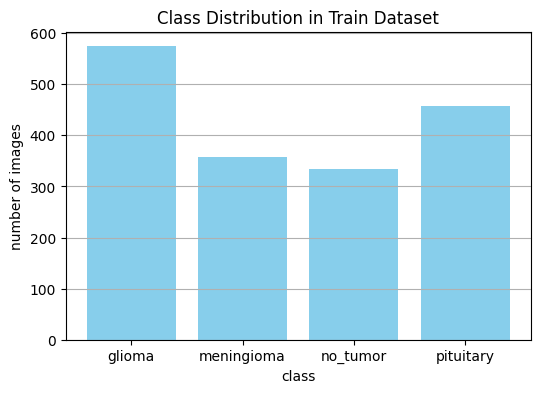

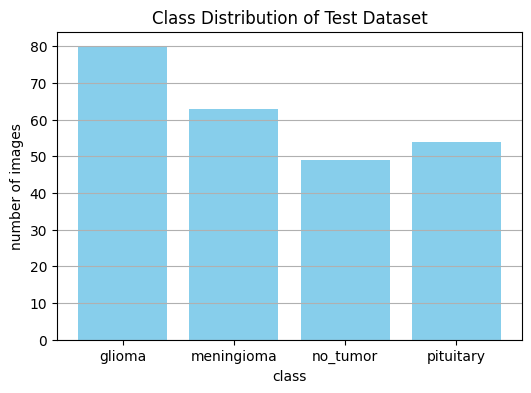

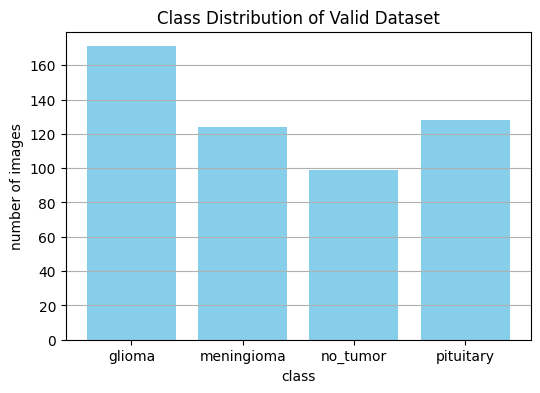

In [5]:
import matplotlib.pyplot as plt
def plot_class_distribution(folder,title):
  class_counts={}
  for class_name in sorted(os.listdir(folder)):
    class_path=os.path.join(folder,class_name)
    if os.path.isdir(class_path):
      class_counts[class_name]=len(os.listdir(class_path))

  plt.figure(figsize=(6,4))
  plt.bar(class_counts.keys(),class_counts.values(),color='skyblue')
  plt.title(title)
  plt.xlabel('class')
  plt.ylabel('number of images')
  plt.grid(axis='y')
  plt.show()

plot_class_distribution(train_dir,'Class Distribution in Train Dataset')
plot_class_distribution(test_dir,'Class Distribution of Test Dataset')
plot_class_distribution(valid_dir,'Class Distribution of Valid Dataset')

**Explore image distribution visually**

In [6]:
import random
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor

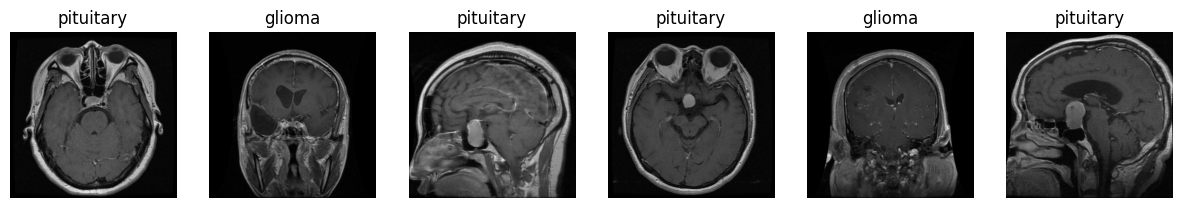

In [7]:
sample_dataset=ImageFolder(train_dir,transform=ToTensor())
def show_images(dataset,n=6):
  fig,axs=plt.subplots(1,n,figsize=(15,4))
  for i in range(n):
    img,label=dataset[random.randint(0,len(dataset)-1)]
    axs[i].imshow(img.permute(1,2,0))
    axs[i].axis('off')
    axs[i].set_title(dataset.classes[label])

  plt.show()
show_images(sample_dataset)

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen=ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'

)
test_datagen=ImageDataGenerator(rescale=(1./255))
valid_datagen=ImageDataGenerator(rescale=(1./255))

train_generator=train_datagen.flow_from_directory(
    train_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical'
)
valid_generator=valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)
test_generator=test_datagen.flow_from_directory(
    test_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 1725 images belonging to 4 classes.
Found 522 images belonging to 4 classes.
Found 246 images belonging to 4 classes.


**Build Model -CNN**

In [9]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Flatten,Dense,Dropout,BatchNormalization

In [10]:
model =Sequential()
model.add(Conv2D(32,(3,3),activation='relu',input_shape=(224,224,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(4,activation='softmax'))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [11]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,170,372 (42.61 MB)

 Trainable params: 11,169,924 (42.61 MB)

 Non-trainable params: 448 (1.75 KB)

In [12]:
history=model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=10,
    validation_data=valid_generator,
    validation_steps=len(valid_generator)
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 673s 12s/step - accuracy: 0.4141 - loss: 13.7067 - val_accuracy: 0.2490 - val_loss: 37.9080
Epoch 2/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 41s 546ms/step - accuracy: 0.4278 - loss: 1.3890 - val_accuracy: 0.2452 - val_loss: 52.6776
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 41s 542ms/step - accuracy: 0.4022 - loss: 1.3280 - val_accuracy: 0.2452 - val_loss: 34.4942
Epoch 4/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 32s 591ms/step - accuracy: 0.4700 - loss: 1.2582 - val_accuracy: 0.2452 - val_loss: 24.3514
Epoch 5/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 31s 568ms/step - accuracy: 0.4731 - loss: 1.2209 - val_accuracy: 0.2797 - val_loss: 11.0459
Epoch 6/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 29s 544ms/step - accuracy: 0.4930 - loss: 1.1896 - val_accuracy: 0.3084 - val_loss: 13.6619
Epoch 7/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 30s 548ms/step - accuracy: 0.4484 - loss: 1.2602 - val_accuracy: 0.2874 - val_loss: 4.1821
Epoch 8/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 43s 588ms/step - accuracy: 0.4976 - loss: 1.2060 - va

In [13]:
def history_plot(history):
  plt.figure(figsize=(12,4))
  plt.subplot(1,2,1)
  plt.plot(history.history['accuracy'],label='Train Accuracy')
  plt.plot(history.history['val_accuracy'],label='Validation Accuracy')
  plt.title('Training vs Validation Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()

  plt.subplot(1,2,2)
  plt.plot(history.history['loss'],label='Training loss')
  plt.plot(history.history['val_loss'],label='Validation loss')
  plt.title('Training vs Validation Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

  plt.tight_layout()
  plt.show()

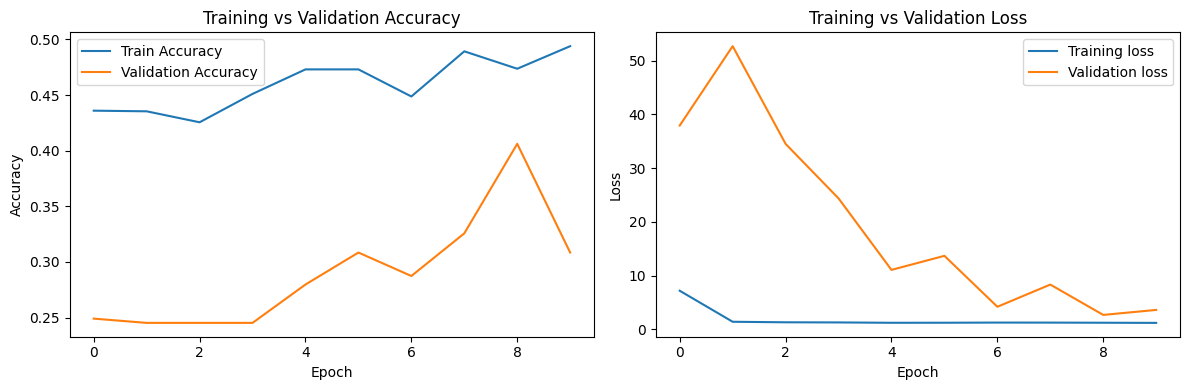

In [14]:
history_plot(history)

In [15]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense,Input,GlobalAveragePooling2D,Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50,MobileNetV2,InceptionV3,EfficientNetB0

In [16]:
def build_model(base_model_class,input_shape=(224,224,3),num_classes=4):
  base_model=base_model_class(weights='imagenet',include_top=False,input_shape=input_shape)
  base_model.trainable=False

  inputs=Input(shape=input_shape)
  x=base_model(inputs,training=False)
  x=GlobalAveragePooling2D()(x)
  x=Dropout(0.5)(x)

  outputs=Dense(num_classes,activation='softmax')(x)

  model=Model(inputs,outputs)
  model.compile(optimizer=Adam(learning_rate=0.0001),
                loss='categorical_crossentropy',
                metrics=['accuracy'])
  return model

In [17]:
resnet_model=build_model(ResNet50)
resnet_model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │         8,196 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,595,908 (90.01 MB)

 Trainable params: 8,196 (32.02 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [18]:
mobilenet_model=build_model(MobileNetV2)
mobilenet_model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │         5,124 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,263,108 (8.63 MB)

 Trainable params: 5,124 (20.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [19]:
inception_model=build_model(InceptionV3)
inception_model.summary()

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_v3 (Functional)       │ (None, 5, 5, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4)              │         8,196 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,810,980 (83.20 MB)

 Trainable params: 8,196 (32.02 KB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [20]:
efficientnet_model=build_model(EfficientNetB0)
efficientnet_model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │         5,124 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,054,695 (15.47 MB)

 Trainable params: 5,124 (20.02 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

**FINE-TUNING**

In [21]:
from tensorflow.keras.optimizers import Adam

In [22]:
def fine_tuned_model(model,num_unfreeze_layers=30,learning_rate=1e-5):
  base_layer=model.layers[1]
  base_layer.trainable=True
  for layer in base_layer.layers[:-num_unfreeze_layers]:
    layer.trainable=False

  model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
  return model

In [23]:
resnet_finetune_model=fine_tuned_model(resnet_model,num_unfreeze_layers=50,learning_rate=1e-5)
resnet_finetune_model.summary()

Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │         8,196 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,595,908 (90.01 MB)

 Trainable params: 16,958,724 (64.69 MB)

 Non-trainable params: 6,637,184 (25.32 MB)

In [24]:
mobilenet_finetune_model=fine_tuned_model(mobilenet_model,num_unfreeze_layers=50,learning_rate=1e-5)
mobilenet_finetune_model.summary()

Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │         5,124 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,263,108 (8.63 MB)

 Trainable params: 1,860,228 (7.10 MB)

 Non-trainable params: 402,880 (1.54 MB)

In [25]:
inception_finetune_model=fine_tuned_model(inception_model,num_unfreeze_layers=50,learning_rate=1e-5)
inception_finetune_model.summary()

Model: "functional_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_v3 (Functional)       │ (None, 5, 5, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4)              │         8,196 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,810,980 (83.20 MB)

 Trainable params: 7,181,508 (27.40 MB)

 Non-trainable params: 14,629,472 (55.81 MB)

In [26]:
efficient_finetune_model=fine_tuned_model(efficientnet_model,num_unfreeze_layers=50,learning_rate=1e-5)
efficient_finetune_model.summary()

Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │         5,124 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,054,695 (15.47 MB)

 Trainable params: 2,531,988 (9.66 MB)

 Non-trainable params: 1,522,707 (5.81 MB)

**MODEL TRAINING**

In [27]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint

In [28]:
early_stop=EarlyStopping(monitor='val_loss',patience=3,restore_best_weights=True)
model_checkpoint=ModelCheckpoint('best_model.h5',monitor='val_loss',save_best_only=True,mode='min',verbose=1)

In [29]:
cnn_history=model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=10,
    callbacks=[early_stop,model_checkpoint],
    steps_per_epoch=len(train_generator),
    validation_steps=len(valid_generator)

)

Epoch 1/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step - accuracy: 0.5264 - loss: 1.1085
Epoch 1: val_loss improved from inf to 1.35550, saving model to best_model.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 30s 558ms/step - accuracy: 0.5261 - loss: 1.1089 - val_accuracy: 0.4291 - val_loss: 1.3555
Epoch 2/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/step - accuracy: 0.4902 - loss: 1.1930
Epoch 2: val_loss did not improve from 1.35550
54/54 ━━━━━━━━━━━━━━━━━━━━ 40s 545ms/step - accuracy: 0.4904 - loss: 1.1922 - val_accuracy: 0.6303 - val_loss: 1.5680
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step - accuracy: 0.5128 - loss: 1.1146
Epoch 3: val_loss did not improve from 1.35550
54/54 ━━━━━━━━━━━━━━━━━━━━ 41s 538ms/step - accuracy: 0.5130 - loss: 1.1148 - val_accuracy: 0.4617 - val_loss: 4.9384
Epoch 4/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step - accuracy: 0.5487 - loss: 1.0920
Epoch 4: val_loss did not improve from 1.35550
54/54 ━━━━━━━━━━━━━━━━━━━━ 32s 594ms/step - accuracy: 0.5484 - loss: 1.0927 - val_accuracy: 0.6169 - val_loss: 1.6800


In [30]:
resnet_history=resnet_model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=10,
    callbacks=[early_stop,model_checkpoint],
    steps_per_epoch=len(train_generator),
    validation_steps=len(valid_generator)
)

Epoch 1/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 762ms/step - accuracy: 0.4204 - loss: 1.3301
Epoch 1: val_loss did not improve from 1.35550
54/54 ━━━━━━━━━━━━━━━━━━━━ 79s 958ms/step - accuracy: 0.4215 - loss: 1.3279 - val_accuracy: 0.1782 - val_loss: 1.7585
Epoch 2/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 514ms/step - accuracy: 0.5651 - loss: 1.0444
Epoch 2: val_loss did not improve from 1.35550
54/54 ━━━━━━━━━━━━━━━━━━━━ 30s 563ms/step - accuracy: 0.5654 - loss: 1.0440 - val_accuracy: 0.2490 - val_loss: 1.8695
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 532ms/step - accuracy: 0.6219 - loss: 0.9299
Epoch 3: val_loss did not improve from 1.35550
54/54 ━━━━━━━━━━━━━━━━━━━━ 42s 585ms/step - accuracy: 0.6220 - loss: 0.9300 - val_accuracy: 0.2835 - val_loss: 1.6983
Epoch 4/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 515ms/step - accuracy: 0.6402 - loss: 0.9106
Epoch 4: val_loss did not improve from 1.35550
54/54 ━━━━━━━━━━━━━━━━━━━━ 40s 568ms/step - accuracy: 0.6402 - loss: 0.9103 - val_accuracy: 0.4253 - val_loss: 1.3

54/54 ━━━━━━━━━━━━━━━━━━━━ 32s 593ms/step - accuracy: 0.6706 - loss: 0.8543 - val_accuracy: 0.5594 - val_loss: 0.9622
Epoch 6/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 517ms/step - accuracy: 0.6973 - loss: 0.7954
Epoch 6: val_loss improved from 0.96224 to 0.72646, saving model to best_model.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 32s 583ms/step - accuracy: 0.6970 - loss: 0.7958 - val_accuracy: 0.6858 - val_loss: 0.7265
Epoch 7/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 512ms/step - accuracy: 0.6874 - loss: 0.7713
Epoch 7: val_loss did not improve from 0.72646
54/54 ━━━━━━━━━━━━━━━━━━━━ 31s 571ms/step - accuracy: 0.6871 - loss: 0.7719 - val_accuracy: 0.6590 - val_loss: 0.8462
Epoch 8/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 520ms/step - accuracy: 0.6665 - loss: 0.8228
Epoch 8: val_loss did not improve from 0.72646
54/54 ━━━━━━━━━━━━━━━━━━━━ 41s 577ms/step - accuracy: 0.6665 - loss: 0.8227 - val_accuracy: 0.6398 - val_loss: 0.9001
Epoch 9/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 521ms/step - accuracy: 0.7037 - loss: 0.7686
Epoch 9: val_loss did not improve from 0.72646
54/54 ━━━━━━━━━━━━━━━━━━━━ 43s 618ms/step - accuracy: 0.7036 - loss: 0.7687 - val_accuracy: 0.7337 - val_loss: 0.7274


In [31]:
mobilenet_history=mobilenet_model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=10,
    callbacks=[early_stop,model_checkpoint],
    steps_per_epoch=len(train_generator),
    validation_steps=len(valid_generator)
)

Epoch 1/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 662ms/step - accuracy: 0.3001 - loss: 1.6679
Epoch 1: val_loss did not improve from 0.72646
54/54 ━━━━━━━━━━━━━━━━━━━━ 67s 840ms/step - accuracy: 0.3013 - loss: 1.6651 - val_accuracy: 0.4789 - val_loss: 1.2778
Epoch 2/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step - accuracy: 0.5078 - loss: 1.2052
Epoch 2: val_loss did not improve from 0.72646
54/54 ━━━━━━━━━━━━━━━━━━━━ 56s 557ms/step - accuracy: 0.5087 - loss: 1.2033 - val_accuracy: 0.5000 - val_loss: 1.1906
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step - accuracy: 0.6606 - loss: 0.8615
Epoch 3: val_loss did not improve from 0.72646
54/54 ━━━━━━━━━━━━━━━━━━━━ 41s 546ms/step - accuracy: 0.6607 - loss: 0.8614 - val_accuracy: 0.5134 - val_loss: 1.1965
Epoch 4/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step - accuracy: 0.7275 - loss: 0.7066
Epoch 4: val_loss did not improve from 0.72646
54/54 ━━━━━━━━━━━━━━━━━━━━ 40s 534ms/step - accuracy: 0.7273 - loss: 0.7068 - val_accuracy: 0.5326 - val_loss: 1.2

In [32]:
inception_history=inception_model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=10,
    callbacks=[early_stop,model_checkpoint],
    steps_per_epoch=len(train_generator),
    validation_steps=len(valid_generator)
)

Epoch 1/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 752ms/step - accuracy: 0.2967 - loss: 1.4549
Epoch 1: val_loss did not improve from 0.72646
54/54 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.2985 - loss: 1.4519 - val_accuracy: 0.6437 - val_loss: 0.8901
Epoch 2/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 527ms/step - accuracy: 0.5970 - loss: 0.9501
Epoch 2: val_loss did not improve from 0.72646
54/54 ━━━━━━━━━━━━━━━━━━━━ 34s 627ms/step - accuracy: 0.5978 - loss: 0.9490 - val_accuracy: 0.7299 - val_loss: 0.7276
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step - accuracy: 0.6964 - loss: 0.7624
Epoch 3: val_loss improved from 0.72646 to 0.60954, saving model to best_model.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 40s 608ms/step - accuracy: 0.6971 - loss: 0.7614 - val_accuracy: 0.7644 - val_loss: 0.6095
Epoch 4/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step - accuracy: 0.7899 - loss: 0.5992
Epoch 4: val_loss improved from 0.60954 to 0.51720, saving model to best_model.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 39s 564ms/step - accuracy: 0.7897 - loss: 0.5994 - val_accuracy: 0.8027 - val_loss: 0.5172
Epoch 5/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step - accuracy: 0.7954 - loss: 0.5472
Epoch 5: val_loss improved from 0.51720 to 0.45325, saving model to best_model.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 41s 561ms/step - accuracy: 0.7956 - loss: 0.5469 - val_accuracy: 0.8333 - val_loss: 0.4533
Epoch 6/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/step - accuracy: 0.8006 - loss: 0.5384
Epoch 6: val_loss improved from 0.45325 to 0.41575, saving model to best_model.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 41s 563ms/step - accuracy: 0.8008 - loss: 0.5378 - val_accuracy: 0.8487 - val_loss: 0.4157
Epoch 7/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 504ms/step - accuracy: 0.8357 - loss: 0.4561
Epoch 7: val_loss improved from 0.41575 to 0.39548, saving model to best_model.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 41s 569ms/step - accuracy: 0.8357 - loss: 0.4562 - val_accuracy: 0.8582 - val_loss: 0.3955
Epoch 8/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/step - accuracy: 0.8451 - loss: 0.4374
Epoch 8: val_loss improved from 0.39548 to 0.38010, saving model to best_model.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 43s 612ms/step - accuracy: 0.8450 - loss: 0.4372 - val_accuracy: 0.8640 - val_loss: 0.3801
Epoch 9/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 502ms/step - accuracy: 0.8626 - loss: 0.3973
Epoch 9: val_loss improved from 0.38010 to 0.35877, saving model to best_model.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 31s 570ms/step - accuracy: 0.8624 - loss: 0.3975 - val_accuracy: 0.8659 - val_loss: 0.3588
Epoch 10/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step - accuracy: 0.8559 - loss: 0.3968
Epoch 10: val_loss improved from 0.35877 to 0.34733, saving model to best_model.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 31s 565ms/step - accuracy: 0.8561 - loss: 0.3964 - val_accuracy: 0.8697 - val_loss: 0.3473


In [33]:
efficientnet_history=efficientnet_model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=10,
    callbacks=[early_stop,model_checkpoint],
    steps_per_epoch=len(train_generator),
    validation_steps=len(valid_generator)
)

Epoch 1/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 759ms/step - accuracy: 0.2509 - loss: 1.4309
Epoch 1: val_loss did not improve from 0.34733
54/54 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - accuracy: 0.2513 - loss: 1.4306 - val_accuracy: 0.2107 - val_loss: 1.3998
Epoch 2/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step - accuracy: 0.3223 - loss: 1.3864
Epoch 2: val_loss did not improve from 0.34733
54/54 ━━━━━━━━━━━━━━━━━━━━ 29s 541ms/step - accuracy: 0.3218 - loss: 1.3865 - val_accuracy: 0.2452 - val_loss: 1.3982
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 513ms/step - accuracy: 0.3042 - loss: 1.3864
Epoch 3: val_loss did not improve from 0.34733
54/54 ━━━━━━━━━━━━━━━━━━━━ 33s 612ms/step - accuracy: 0.3042 - loss: 1.3864 - val_accuracy: 0.2452 - val_loss: 1.3849
Epoch 4/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step - accuracy: 0.2898 - loss: 1.3902
Epoch 4: val_loss did not improve from 0.34733
54/54 ━━━━━━━━━━━━━━━━━━━━ 29s 537ms/step - accuracy: 0.2899 - loss: 1.3902 - val_accuracy: 0.3314 - val_loss: 1.3776

In [34]:
def history_plot(history, title='Model Performance'):
    plt.figure(figsize=(12, 4))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title(title + ' - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(title + ' - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

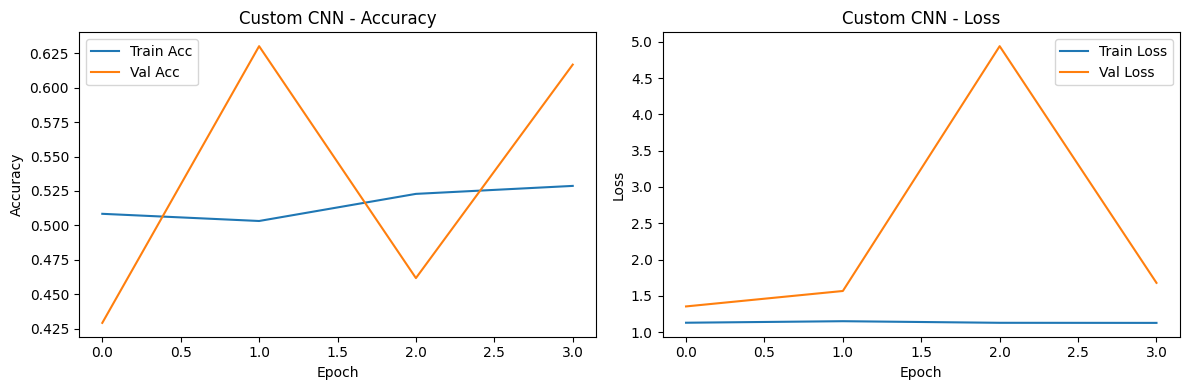

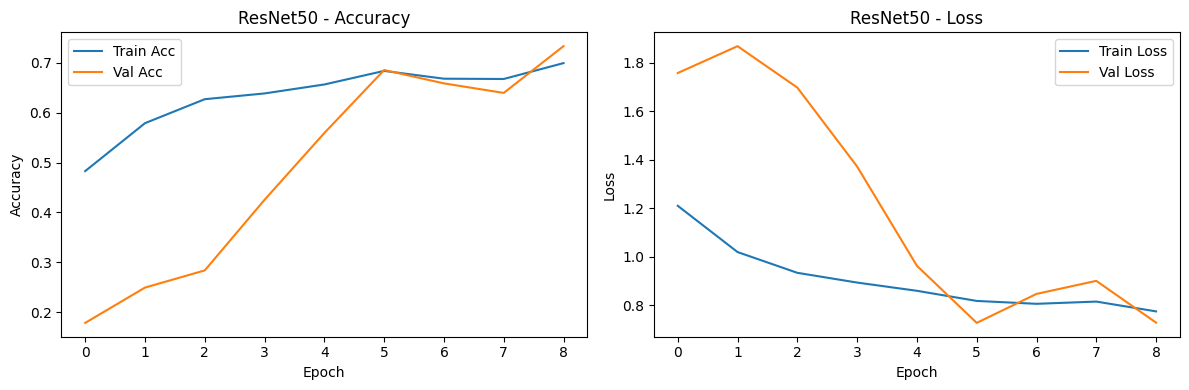

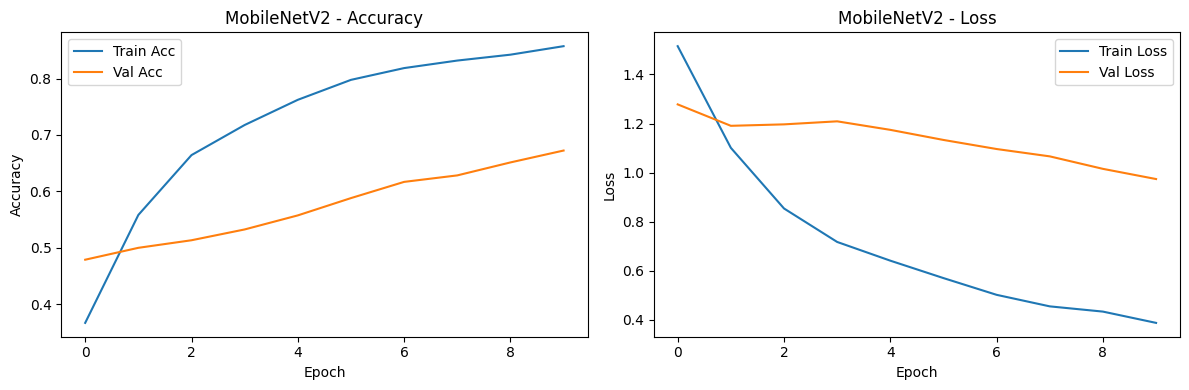

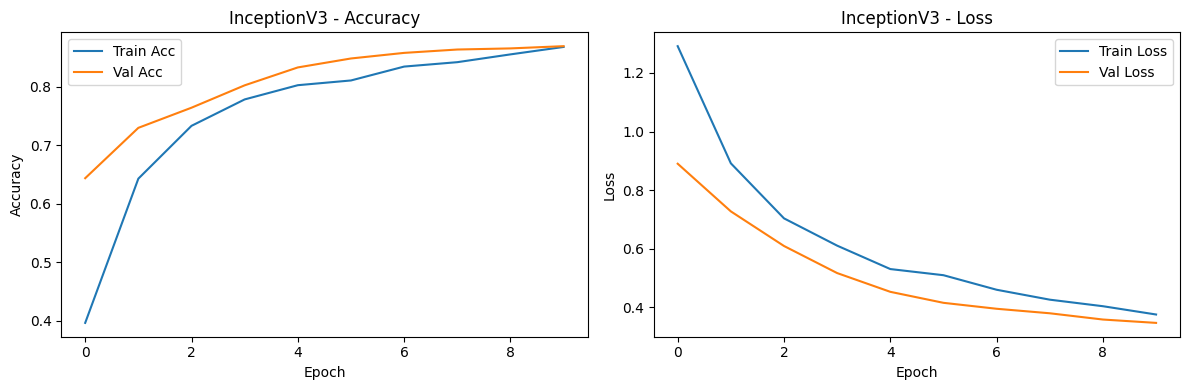

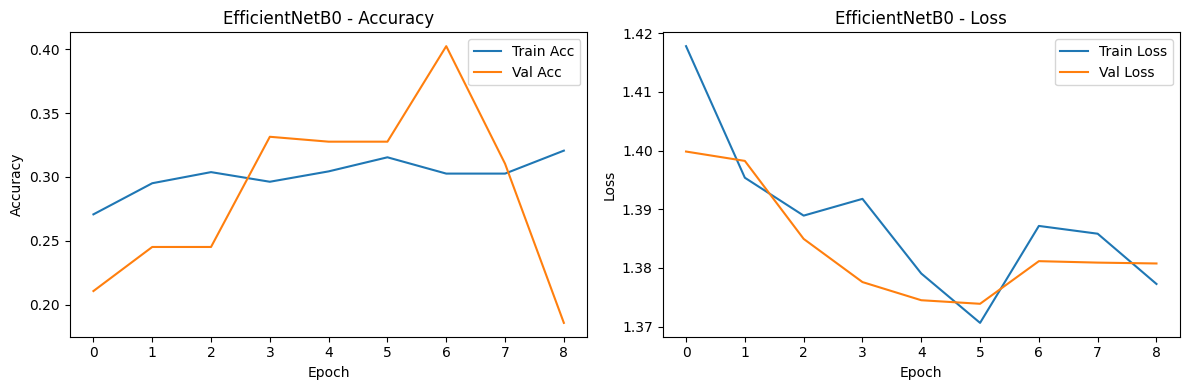

In [35]:
history_plot(cnn_history, title='Custom CNN')
history_plot(resnet_history, title='ResNet50')
history_plot(mobilenet_history, title='MobileNetV2')
history_plot(inception_history, title='InceptionV3')
history_plot(efficientnet_history, title='EfficientNetB0')

MODEL TRAINING-FINE TUNing

In [36]:
resnet_finetune_history=resnet_finetune_model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=10,
    callbacks=[early_stop,model_checkpoint],
    steps_per_epoch=len(train_generator),
    validation_steps=len(valid_generator)
)

Epoch 1/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 531ms/step - accuracy: 0.6823 - loss: 0.8017
Epoch 1: val_loss did not improve from 0.34733
54/54 ━━━━━━━━━━━━━━━━━━━━ 32s 595ms/step - accuracy: 0.6825 - loss: 0.8012 - val_accuracy: 0.6667 - val_loss: 0.8109
Epoch 2/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 512ms/step - accuracy: 0.6917 - loss: 0.7828
Epoch 2: val_loss did not improve from 0.34733
54/54 ━━━━━━━━━━━━━━━━━━━━ 39s 566ms/step - accuracy: 0.6916 - loss: 0.7827 - val_accuracy: 0.6992 - val_loss: 0.7447
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 510ms/step - accuracy: 0.6872 - loss: 0.7741
Epoch 3: val_loss did not improve from 0.34733
54/54 ━━━━━━━━━━━━━━━━━━━━ 41s 572ms/step - accuracy: 0.6873 - loss: 0.7739 - val_accuracy: 0.7222 - val_loss: 0.7209
Epoch 4/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 513ms/step - accuracy: 0.6961 - loss: 0.7699
Epoch 4: val_loss did not improve from 0.34733
54/54 ━━━━━━━━━━━━━━━━━━━━ 33s 612ms/step - accuracy: 0.6960 - loss: 0.7702 - val_accuracy: 0.7299 - val_loss: 0.6

In [37]:
mobilenet_finetune_history=mobilenet_finetune_model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=10,
    callbacks=[early_stop,model_checkpoint],
    steps_per_epoch=len(train_generator),
    validation_steps=len(valid_generator)
)

Epoch 1/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 505ms/step - accuracy: 0.8424 - loss: 0.4249
Epoch 1: val_loss did not improve from 0.34733
54/54 ━━━━━━━━━━━━━━━━━━━━ 33s 610ms/step - accuracy: 0.8426 - loss: 0.4244 - val_accuracy: 0.6877 - val_loss: 0.9338
Epoch 2/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step - accuracy: 0.8512 - loss: 0.3886
Epoch 2: val_loss did not improve from 0.34733
54/54 ━━━━━━━━━━━━━━━━━━━━ 29s 535ms/step - accuracy: 0.8514 - loss: 0.3883 - val_accuracy: 0.7011 - val_loss: 0.8742
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step - accuracy: 0.8635 - loss: 0.3775
Epoch 3: val_loss did not improve from 0.34733
54/54 ━━━━━━━━━━━━━━━━━━━━ 29s 534ms/step - accuracy: 0.8636 - loss: 0.3771 - val_accuracy: 0.7165 - val_loss: 0.8134
Epoch 4/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step - accuracy: 0.8741 - loss: 0.3486
Epoch 4: val_loss did not improve from 0.34733
54/54 ━━━━━━━━━━━━━━━━━━━━ 29s 536ms/step - accuracy: 0.8743 - loss: 0.3483 - val_accuracy: 0.7241 - val_loss: 0.7

In [38]:
inception_finetune_history=inception_finetune_model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=10,
    callbacks=[early_stop,model_checkpoint],
    steps_per_epoch=len(train_generator),
    validation_steps=len(valid_generator)
)

Epoch 1/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step - accuracy: 0.8747 - loss: 0.3360
Epoch 1: val_loss improved from 0.34733 to 0.33251, saving model to best_model.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 31s 571ms/step - accuracy: 0.8747 - loss: 0.3361 - val_accuracy: 0.8659 - val_loss: 0.3325
Epoch 2/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/step - accuracy: 0.8885 - loss: 0.3139
Epoch 2: val_loss improved from 0.33251 to 0.32058, saving model to best_model.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 41s 563ms/step - accuracy: 0.8884 - loss: 0.3141 - val_accuracy: 0.8793 - val_loss: 0.3206
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step - accuracy: 0.8838 - loss: 0.3339
Epoch 3: val_loss improved from 0.32058 to 0.31193, saving model to best_model.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 41s 565ms/step - accuracy: 0.8837 - loss: 0.3339 - val_accuracy: 0.8793 - val_loss: 0.3119
Epoch 4/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 503ms/step - accuracy: 0.8871 - loss: 0.3255
Epoch 4: val_loss improved from 0.31193 to 0.30262, saving model to best_model.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 31s 572ms/step - accuracy: 0.8871 - loss: 0.3254 - val_accuracy: 0.8793 - val_loss: 0.3026
Epoch 5/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 516ms/step - accuracy: 0.9053 - loss: 0.2717
Epoch 5: val_loss improved from 0.30262 to 0.29982, saving model to best_model.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 41s 580ms/step - accuracy: 0.9051 - loss: 0.2720 - val_accuracy: 0.8870 - val_loss: 0.2998
Epoch 6/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 505ms/step - accuracy: 0.8965 - loss: 0.2861
Epoch 6: val_loss improved from 0.29982 to 0.29229, saving model to best_model.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 31s 570ms/step - accuracy: 0.8966 - loss: 0.2859 - val_accuracy: 0.8889 - val_loss: 0.2923
Epoch 7/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 505ms/step - accuracy: 0.9027 - loss: 0.2606
Epoch 7: val_loss improved from 0.29229 to 0.28953, saving model to best_model.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 32s 580ms/step - accuracy: 0.9028 - loss: 0.2605 - val_accuracy: 0.8927 - val_loss: 0.2895
Epoch 8/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/step - accuracy: 0.9101 - loss: 0.2576
Epoch 8: val_loss improved from 0.28953 to 0.28364, saving model to best_model.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 30s 564ms/step - accuracy: 0.9101 - loss: 0.2575 - val_accuracy: 0.9080 - val_loss: 0.2836
Epoch 9/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step - accuracy: 0.9140 - loss: 0.2346
Epoch 9: val_loss improved from 0.28364 to 0.28155, saving model to best_model.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 41s 560ms/step - accuracy: 0.9138 - loss: 0.2348 - val_accuracy: 0.9061 - val_loss: 0.2816
Epoch 10/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step - accuracy: 0.9046 - loss: 0.2561
Epoch 10: val_loss improved from 0.28155 to 0.27834, saving model to best_model.h5


54/54 ━━━━━━━━━━━━━━━━━━━━ 41s 558ms/step - accuracy: 0.9048 - loss: 0.2558 - val_accuracy: 0.9061 - val_loss: 0.2783


In [39]:
efficient_finetune_history=efficient_finetune_model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=10,
    callbacks=[early_stop,model_checkpoint],
    steps_per_epoch=len(train_generator),
    validation_steps=len(valid_generator)
)

Epoch 1/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step - accuracy: 0.3219 - loss: 1.3897
Epoch 1: val_loss did not improve from 0.27834
54/54 ━━━━━━━━━━━━━━━━━━━━ 30s 553ms/step - accuracy: 0.3218 - loss: 1.3896 - val_accuracy: 0.2778 - val_loss: 1.3817
Epoch 2/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step - accuracy: 0.3126 - loss: 1.3716
Epoch 2: val_loss did not improve from 0.27834
54/54 ━━━━━━━━━━━━━━━━━━━━ 30s 562ms/step - accuracy: 0.3127 - loss: 1.3718 - val_accuracy: 0.3314 - val_loss: 1.3783
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step - accuracy: 0.3295 - loss: 1.3626
Epoch 3: val_loss did not improve from 0.27834
54/54 ━━━━━━━━━━━━━━━━━━━━ 29s 539ms/step - accuracy: 0.3294 - loss: 1.3626 - val_accuracy: 0.1897 - val_loss: 1.3874
Epoch 4/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step - accuracy: 0.3183 - loss: 1.3647
Epoch 4: val_loss did not improve from 0.27834
54/54 ━━━━━━━━━━━━━━━━━━━━ 29s 537ms/step - accuracy: 0.3184 - loss: 1.3647 - val_accuracy: 0.1897 - val_loss: 1.4

**MODEL EVALUATION**

In [40]:
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,f1_score,precision_score,recall_score
import numpy as np
import seaborn as sns

**CUSTOM-CNN**

17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 164ms/step

 Classification Report 

              precision    recall  f1-score   support

      glioma       0.89      0.60      0.72       171
  meningioma       0.41      0.24      0.30       124
    no_tumor       0.29      0.72      0.41        99
   pituitary       0.22      0.16      0.18       128

    accuracy                           0.43       522
   macro avg       0.45      0.43      0.41       522
weighted avg       0.50      0.43      0.43       522

Accuracy:0.4291
Precision:0.4988
F1_score:0.4312
Recall_score:0.4291


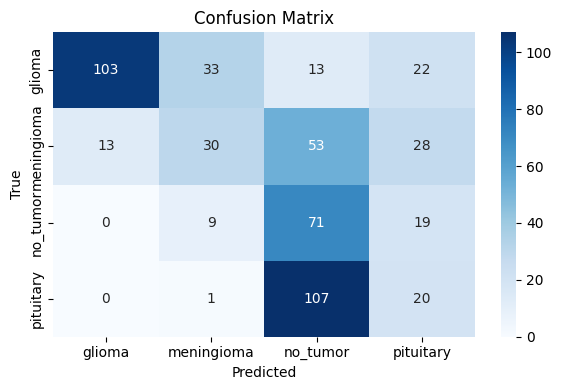

In [41]:
y_pred_probs=model.predict(valid_generator)
y_pred=np.argmax(y_pred_probs,axis=1)
y_true=valid_generator.classes

accuracy=accuracy_score(y_true,y_pred)
precision=precision_score(y_true,y_pred,average='weighted')
f1=f1_score(y_true,y_pred,average='weighted')
recall=recall_score(y_true,y_pred,average='weighted')

target_names=list(valid_generator.class_indices.keys())
print("\n Classification Report \n")
print(classification_report(y_true,y_pred,target_names=target_names))

print(f"Accuracy:{accuracy:.4f}")
print(f"Precision:{precision:.4f}")
print(f"F1_score:{f1:.4f}")
print(f"Recall_score:{recall:.4f}")

cm=confusion_matrix(y_true,y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm,annot=True,fmt='d',cmap='Blues',xticklabels=target_names,yticklabels=target_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


**ResNet50**

17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 437ms/step

 Classification Report 

              precision    recall  f1-score   support

      glioma       0.78      0.81      0.79       171
  meningioma       0.63      0.43      0.51       124
    no_tumor       0.75      0.84      0.79        99
   pituitary       0.72      0.84      0.77       128

    accuracy                           0.73       522
   macro avg       0.72      0.73      0.72       522
weighted avg       0.72      0.73      0.72       522

Accuracy:0.7299
Precision:0.7218
F1_score:0.7195
Recall_score:0.7299


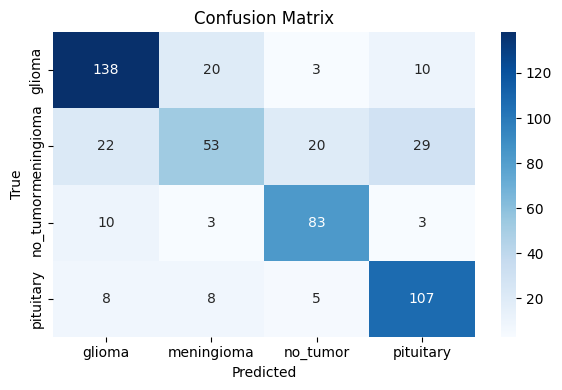

In [42]:
y_pred_probs=resnet_model.predict(valid_generator)
y_pred=np.argmax(y_pred_probs,axis=1)
y_true=valid_generator.classes

accuracy=accuracy_score(y_true,y_pred)
precision=precision_score(y_true,y_pred,average='weighted')
f1=f1_score(y_true,y_pred,average='weighted')
recall=recall_score(y_true,y_pred,average='weighted')

target_names=list(valid_generator.class_indices.keys())
print("\n Classification Report \n")
print(classification_report(y_true,y_pred,target_names=target_names))

print(f"Accuracy:{accuracy:.4f}")
print(f"Precision:{precision:.4f}")
print(f"F1_score:{f1:.4f}")
print(f"Recall_score:{recall:.4f}")

cm=confusion_matrix(y_true,y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm,annot=True,fmt='d',cmap='Blues',xticklabels=target_names,yticklabels=target_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


**MobileNetV2**

17/17 ━━━━━━━━━━━━━━━━━━━━ 8s 323ms/step

 Classification Report 

              precision    recall  f1-score   support

      glioma       0.75      1.00      0.85       171
  meningioma       0.98      0.34      0.50       124
    no_tumor       0.89      0.84      0.86        99
   pituitary       0.79      0.97      0.87       128

    accuracy                           0.80       522
   macro avg       0.85      0.79      0.77       522
weighted avg       0.84      0.80      0.78       522

Accuracy:0.8046
Precision:0.8396
F1_score:0.7769
Recall_score:0.8046


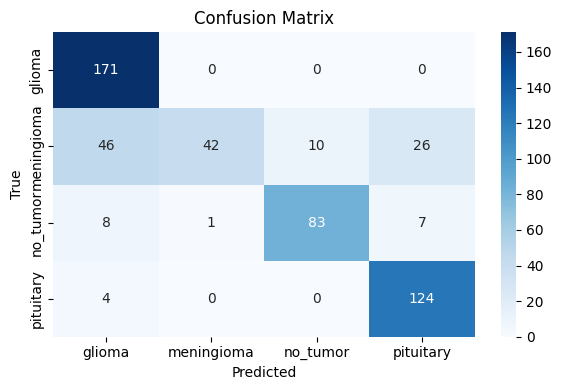

In [43]:
y_pred_probs=mobilenet_model.predict(valid_generator)
y_pred=np.argmax(y_pred_probs,axis=1)
y_true=valid_generator.classes

accuracy=accuracy_score(y_true,y_pred)
precision=precision_score(y_true,y_pred,average='weighted')
f1=f1_score(y_true,y_pred,average='weighted')
recall=recall_score(y_true,y_pred,average='weighted')

target_names=list(valid_generator.class_indices.keys())
print("\n Classification Report \n")
print(classification_report(y_true,y_pred,target_names=target_names))

print(f"Accuracy:{accuracy:.4f}")
print(f"Precision:{precision:.4f}")
print(f"F1_score:{f1:.4f}")
print(f"Recall_score:{recall:.4f}")

cm=confusion_matrix(y_true,y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm,annot=True,fmt='d',cmap='Blues',xticklabels=target_names,yticklabels=target_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


**InceptionV3**

17/17 ━━━━━━━━━━━━━━━━━━━━ 15s 556ms/step

 Classification Report 

              precision    recall  f1-score   support

      glioma       0.97      0.98      0.97       171
  meningioma       0.91      0.73      0.81       124
    no_tumor       0.90      0.92      0.91        99
   pituitary       0.84      0.97      0.90       128

    accuracy                           0.91       522
   macro avg       0.90      0.90      0.90       522
weighted avg       0.91      0.91      0.90       522

Accuracy:0.9061
Precision:0.9086
F1_score:0.9037
Recall_score:0.9061


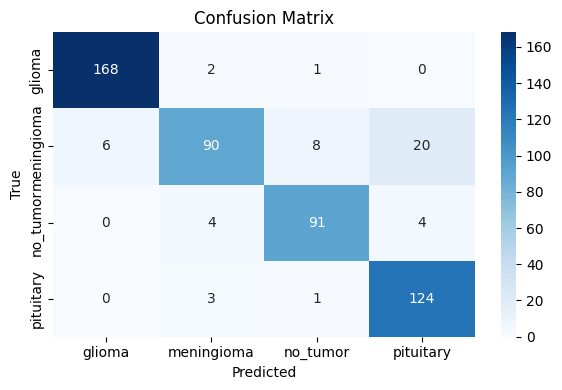

In [44]:
y_pred_probs=inception_model.predict(valid_generator)
y_pred=np.argmax(y_pred_probs,axis=1)
y_true=valid_generator.classes

accuracy=accuracy_score(y_true,y_pred)
precision=precision_score(y_true,y_pred,average='weighted')
f1=f1_score(y_true,y_pred,average='weighted')
recall=recall_score(y_true,y_pred,average='weighted')

target_names=list(valid_generator.class_indices.keys())
print("\n Classification Report \n")
print(classification_report(y_true,y_pred,target_names=target_names))

print(f"Accuracy:{accuracy:.4f}")
print(f"Precision:{precision:.4f}")
print(f"F1_score:{f1:.4f}")
print(f"Recall_score:{recall:.4f}")

cm=confusion_matrix(y_true,y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm,annot=True,fmt='d',cmap='Blues',xticklabels=target_names,yticklabels=target_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


**EfficientNetB0**

17/17 ━━━━━━━━━━━━━━━━━━━━ 14s 522ms/step

 Classification Report 

              precision    recall  f1-score   support

      glioma       0.00      0.00      0.00       171
  meningioma       0.00      0.00      0.00       124
    no_tumor       0.51      0.66      0.57        99
   pituitary       0.27      0.84      0.41       128

    accuracy                           0.33       522
   macro avg       0.20      0.38      0.25       522
weighted avg       0.16      0.33      0.21       522

Accuracy:0.3314
Precision:0.1635
F1_score:0.2101
Recall_score:0.3314


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

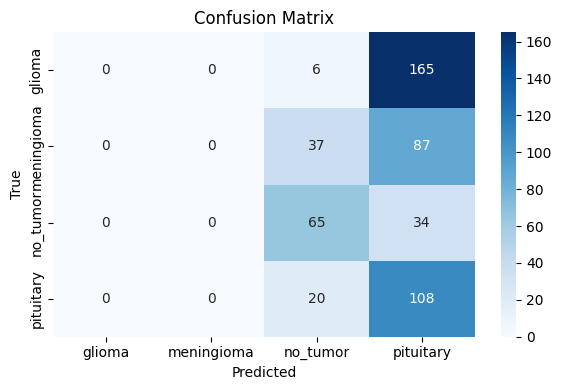

In [45]:
y_pred_probs=efficientnet_model.predict(valid_generator)
y_pred=np.argmax(y_pred_probs,axis=1)
y_true=valid_generator.classes

accuracy=accuracy_score(y_true,y_pred)
precision=precision_score(y_true,y_pred,average='weighted')
f1=f1_score(y_true,y_pred,average='weighted')
recall=recall_score(y_true,y_pred,average='weighted')

target_names=list(valid_generator.class_indices.keys())
print("\n Classification Report \n")
print(classification_report(y_true,y_pred,target_names=target_names))

print(f"Accuracy:{accuracy:.4f}")
print(f"Precision:{precision:.4f}")
print(f"F1_score:{f1:.4f}")
print(f"Recall_score:{recall:.4f}")

cm=confusion_matrix(y_true,y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm,annot=True,fmt='d',cmap='Blues',xticklabels=target_names,yticklabels=target_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


**MODEL EVALUATION-FINE TUNING**

**ResNet50-FINE TUNING**

17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step

 Classification Report 

              precision    recall  f1-score   support

      glioma       0.78      0.81      0.79       171
  meningioma       0.63      0.43      0.51       124
    no_tumor       0.75      0.84      0.79        99
   pituitary       0.72      0.84      0.77       128

    accuracy                           0.73       522
   macro avg       0.72      0.73      0.72       522
weighted avg       0.72      0.73      0.72       522

Accuracy:0.7299
Precision:0.7218
F1_score:0.7195
Recall_score:0.7299


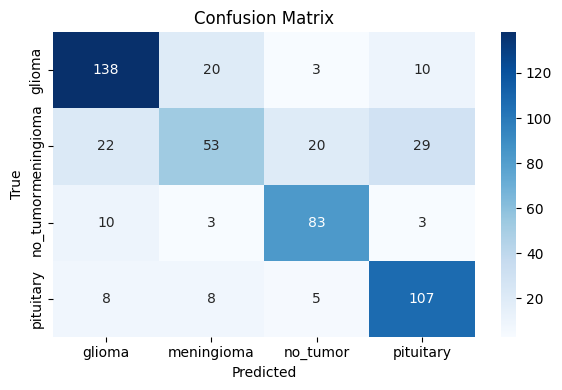

In [46]:
y_pred_probs=resnet_finetune_model.predict(valid_generator)
y_pred=np.argmax(y_pred_probs,axis=1)
y_true=valid_generator.classes

accuracy=accuracy_score(y_true,y_pred)
precision=precision_score(y_true,y_pred,average='weighted')
f1=f1_score(y_true,y_pred,average='weighted')
recall=recall_score(y_true,y_pred,average='weighted')

target_names=list(valid_generator.class_indices.keys())
print("\n Classification Report \n")
print(classification_report(y_true,y_pred,target_names=target_names))

print(f"Accuracy:{accuracy:.4f}")
print(f"Precision:{precision:.4f}")
print(f"F1_score:{f1:.4f}")
print(f"Recall_score:{recall:.4f}")

cm=confusion_matrix(y_true,y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm,annot=True,fmt='d',cmap='Blues',xticklabels=target_names,yticklabels=target_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

**MobileNetV2-FINE TUNING**

17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 172ms/step

 Classification Report 

              precision    recall  f1-score   support

      glioma       0.75      1.00      0.85       171
  meningioma       0.98      0.34      0.50       124
    no_tumor       0.89      0.84      0.86        99
   pituitary       0.79      0.97      0.87       128

    accuracy                           0.80       522
   macro avg       0.85      0.79      0.77       522
weighted avg       0.84      0.80      0.78       522

Accuracy:0.8046
Precision:0.8396
F1_score:0.7769
Recall_score:0.8046


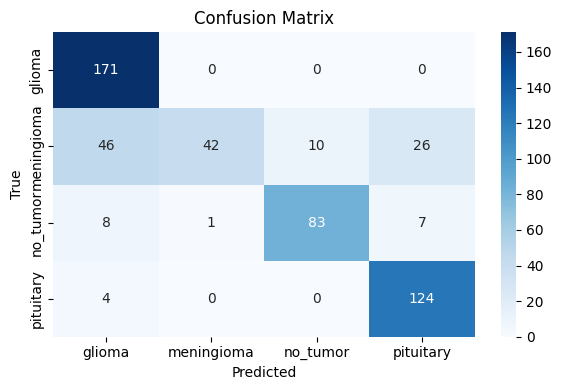

In [47]:
y_pred_probs=mobilenet_finetune_model.predict(valid_generator)
y_pred=np.argmax(y_pred_probs,axis=1)
y_true=valid_generator.classes

accuracy=accuracy_score(y_true,y_pred)
precision=precision_score(y_true,y_pred,average='weighted')
f1=f1_score(y_true,y_pred,average='weighted')
recall=recall_score(y_true,y_pred,average='weighted')

target_names=list(valid_generator.class_indices.keys())
print("\n Classification Report \n")
print(classification_report(y_true,y_pred,target_names=target_names))

print(f"Accuracy:{accuracy:.4f}")
print(f"Precision:{precision:.4f}")
print(f"F1_score:{f1:.4f}")
print(f"Recall_score:{recall:.4f}")

cm=confusion_matrix(y_true,y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm,annot=True,fmt='d',cmap='Blues',xticklabels=target_names,yticklabels=target_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

**InceptionV3-FINE TUNING**

17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 153ms/step

 Classification Report 

              precision    recall  f1-score   support

      glioma       0.97      0.98      0.97       171
  meningioma       0.91      0.73      0.81       124
    no_tumor       0.90      0.92      0.91        99
   pituitary       0.84      0.97      0.90       128

    accuracy                           0.91       522
   macro avg       0.90      0.90      0.90       522
weighted avg       0.91      0.91      0.90       522

Accuracy:0.9061
Precision:0.9086
F1_score:0.9037
Recall_score:0.9061


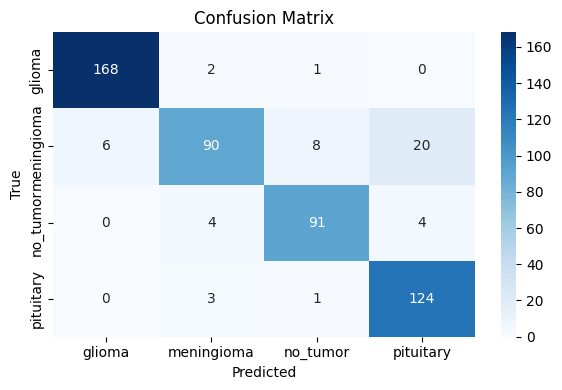

In [48]:
y_pred_probs=inception_finetune_model.predict(valid_generator)
y_pred=np.argmax(y_pred_probs,axis=1)
y_true=valid_generator.classes

accuracy=accuracy_score(y_true,y_pred)
precision=precision_score(y_true,y_pred,average='weighted')
f1=f1_score(y_true,y_pred,average='weighted')
recall=recall_score(y_true,y_pred,average='weighted')

target_names=list(valid_generator.class_indices.keys())
print("\n Classification Report \n")
print(classification_report(y_true,y_pred,target_names=target_names))

print(f"Accuracy:{accuracy:.4f}")
print(f"Precision:{precision:.4f}")
print(f"F1_score:{f1:.4f}")
print(f"Recall_score:{recall:.4f}")

cm=confusion_matrix(y_true,y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm,annot=True,fmt='d',cmap='Blues',xticklabels=target_names,yticklabels=target_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

**EfficientNetB0-FINE TUNING**

17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step

 Classification Report 

              precision    recall  f1-score   support

      glioma       0.00      0.00      0.00       171
  meningioma       0.00      0.00      0.00       124
    no_tumor       0.51      0.66      0.57        99
   pituitary       0.27      0.84      0.41       128

    accuracy                           0.33       522
   macro avg       0.20      0.38      0.25       522
weighted avg       0.16      0.33      0.21       522

Accuracy:0.3314
Precision:0.1635
F1_score:0.2101
Recall_score:0.3314


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

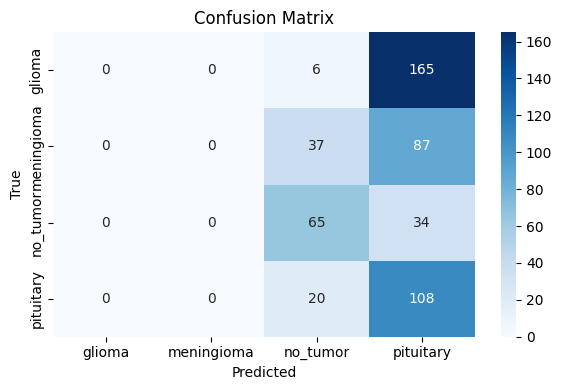

In [49]:
y_pred_probs=efficient_finetune_model.predict(valid_generator)
y_pred=np.argmax(y_pred_probs,axis=1)
y_true=valid_generator.classes

accuracy=accuracy_score(y_true,y_pred)
precision=precision_score(y_true,y_pred,average='weighted')
f1=f1_score(y_true,y_pred,average='weighted')
recall=recall_score(y_true,y_pred,average='weighted')

target_names=list(valid_generator.class_indices.keys())
print("\n Classification Report \n")
print(classification_report(y_true,y_pred,target_names=target_names))

print(f"Accuracy:{accuracy:.4f}")
print(f"Precision:{precision:.4f}")
print(f"F1_score:{f1:.4f}")
print(f"Recall_score:{recall:.4f}")

cm=confusion_matrix(y_true,y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm,annot=True,fmt='d',cmap='Blues',xticklabels=target_names,yticklabels=target_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

**MODEL COMPARSION**

/tmp/ipython-input-50-142138210.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models,y=values,palette='viridis')
/tmp/ipython-input-50-142138210.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models,y=values,palette='viridis')
/tmp/ipython-input-50-142138210.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models,y=values,palette='viridis')
/tmp/ipython-input-50-142138210.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and 

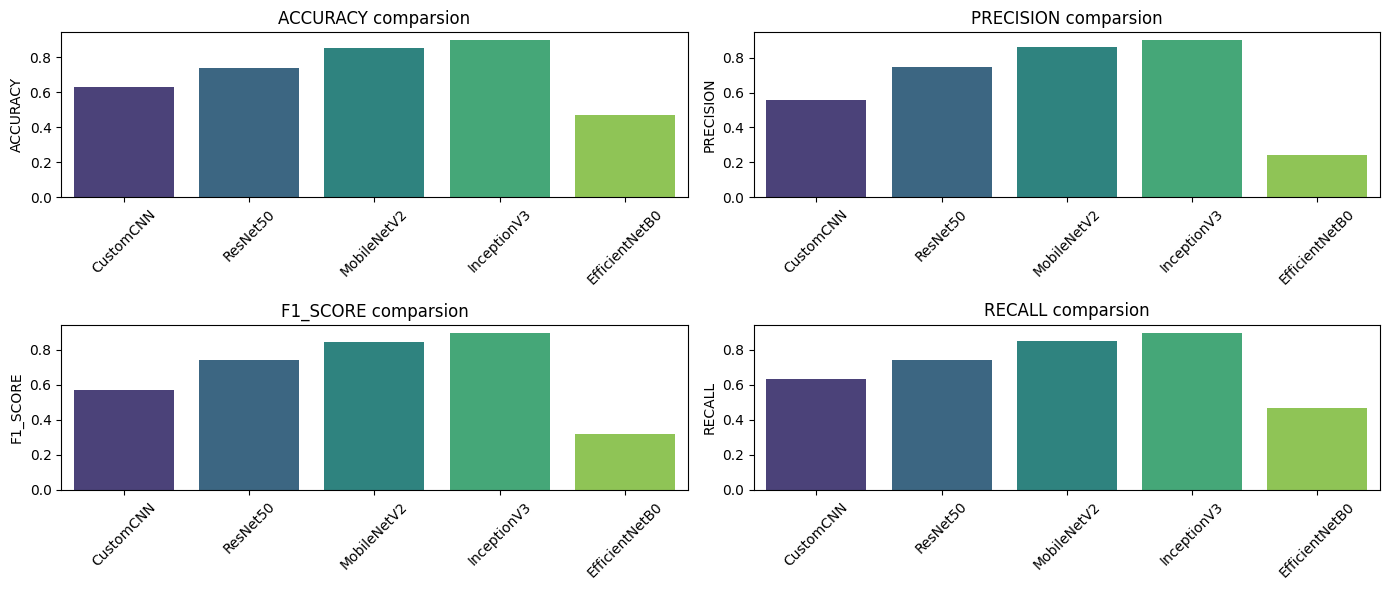

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns

models = ['CustomCNN', 'ResNet50', 'MobileNetV2', 'InceptionV3', 'EfficientNetB0']
accuracy = [0.6322, 0.7414, 0.8525, 0.8985, 0.4693]
precision = [0.5562, 0.7440, 0.8619, 0.8991, 0.2434]
f1_score = [0.5681, 0.7423, 0.8408, 0.8959, 0.3196]
recall = [0.6322, 0.7414, 0.8525, 0.8985, 0.4693]

metrics_dict={'ACCURACY':accuracy,'PRECISION':precision,'F1_SCORE':f1_score,'RECALL':recall}

plt.figure(figsize=(14,6))
for i,(metrics_name,values) in enumerate(metrics_dict.items()):
  plt.subplot(2,2,i+1)
  sns.barplot(x=models,y=values,palette='viridis')
  plt.title(f'{metrics_name} comparsion')
  plt.ylabel(metrics_name)
  plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8/8 ━━━━━━━━━━━━━━━━━━━━ 89s 13s/step

Classification Report

              precision    recall  f1-score   support

      glioma       0.94      0.97      0.96        80
  meningioma       0.92      0.75      0.82        63
    no_tumor       0.88      0.88      0.88        49
   pituitary       0.86      1.00      0.92        54

    accuracy                           0.90       246
   macro avg       0.90      0.90      0.90       246
weighted avg       0.90      0.90      0.90       246

Accuracy     : 0.9024
Precision    : 0.9046
F1 Score     : 0.8998
Recall Score : 0.9024


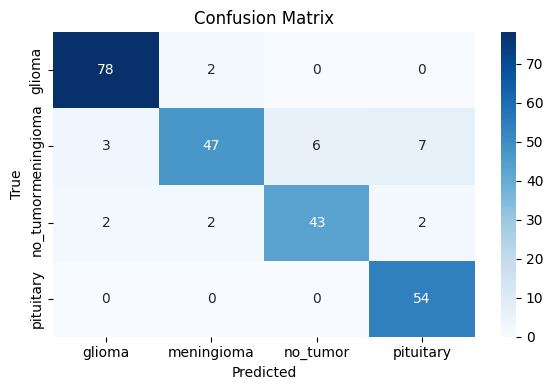

In [51]:
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Predict class probabilities
y_pred_probs = inception_finetune_model.predict(test_generator)

# Get predicted class indices
y_pred = np.argmax(y_pred_probs, axis=1)

# Get true class labels
y_true = test_generator.classes

# Accuracy, precision, recall, F1-score
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')

# Re-import f1_score to avoid accidental overwrite
from sklearn.metrics import f1_score
f1_value = f1_score(y_true, y_pred, average='weighted')

recall = recall_score(y_true, y_pred, average='weighted')

# Classification report
target_names = list(test_generator.class_indices.keys())
print("\nClassification Report\n")
print(classification_report(y_true, y_pred, target_names=target_names))

# Print metrics
print(f"Accuracy     : {accuracy:.4f}")
print(f"Precision    : {precision:.4f}")
print(f"F1 Score     : {f1_value:.4f}")
print(f"Recall Score : {recall:.4f}")

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

INCEPTIONV3 MODEL PERFORMING WELL

In [52]:
inception_finetune_model.save('/content/drive/MyDrive/inception_finetune_model.h5')

In [53]:
!ls "/content/drive/MyDrive"

 20190709_173706.png
 20190709_173728.png
 20190709_173757.png
 20190709_173817.png
 20190709_173841.png
 20190709_173859.png
 20190709_173917.png
 20190709_173940.png
 20190709_174024.png
 20190709_174045.png
'Audio from Deva'
 brain_tumor_dataset
 brain_tumor_dataset-20250716T162308Z-1-001.zip
'CamScanner_09-14-2020_15.29.34 (1).pdf'
 CamScanner_09-14-2020_15.29.34.pdf
'Certificate for Devadarsheni.M.G for "Concrete Building Restorati...".pdf'
'Colab Notebooks'
'DEEP LEARNING'
'Devadarsheni resume (1).docx'
'Devadarsheni resume.docx'
'Document from Deva.pdf'
'EDA AND DE'
'Getting started.pdf'
 IMG-20221106-WA0023.jpg
 inception_finetune_model.h5
'Machine Learning'
'pratice drawing.dwg'
 unit-1-sources-and-effects-of-air.pptx
 Visualization


In [54]:
!cp /content/drive/MyDrive/inception_finetune_model.h5 /content/

In [55]:
from google.colab import files
files.download('/content/inception_finetune_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**STREAMLIT**

In [57]:
!pip install streamlit streamlit-option-menu -q
!npm install -g localtunnel

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 87.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 829.3/829.3 kB 45.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 104.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 7.5 MB/s eta 0:00:00
⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧
added 22 packages in 2s
⠧
⠧3 packages are looking for funding
⠧  run `npm fund` for details
⠧

In [58]:
%%writefile app.py

import streamlit as st
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
import os

@st.cache_resource
def load_brain_tumor_model():
    MODEL_PATH = "/content/drive/MyDrive/inception_finetune_model.h5"
    if not os.path.exists(MODEL_PATH):
        st.error(f"Model file not found at path: {MODEL_PATH}")
        return None
    model = load_model(MODEL_PATH)
    return model


model = load_brain_tumor_model()

class_names = ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']

st.set_page_config(page_title="Brain Tumor Detection", layout="wide")
st.title("Brain Tumor MRI Classifier")

uploaded_file = st.file_uploader("Upload a Brain MRI Image", type=["jpg", "jpeg", "png"])

if uploaded_file:
    image = Image.open(uploaded_file).convert('RGB')
    st.image(image, caption='Uploaded MRI Image', use_column_width=True)

    image = image.resize((224, 224))
    image_array = img_to_array(image)
    image_array = np.expand_dims(image_array, axis=0)
    image_array = image_array / 255.0

    predictions = model.predict(image_array)[0]
    predicted_idx = np.argmax(predictions)
    confidence = predictions[predicted_idx]

    st.subheader("Prediction")
    st.markdown(f"**Tumor Type:** `{class_names[predicted_idx]}`")
    st.markdown(f"**Confidence Score:** `{confidence * 100:.2f}%`")

    st.subheader("Class-wise Confidence Scores")
    for i, prob in enumerate(predictions):
        st.write(f"{class_names[i]}: {prob * 100:.2f}%")



Writing app.py


In [67]:
!streamlit run app.py &>/content/logs.txt &

In [68]:
!wget -q -O - ipv4.icanhazip.com

34.83.169.134


In [69]:
!npx localtunnel --port 8501

⠙⠹⠸⠼⠴⠦⠧⠇⠏your url is: https://cruel-donkeys-check.loca.lt
^C
